In [ ]:
# !pip install shap
# ! pip install catboost

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report
from sklearn.metrics import roc_curve, roc_auc_score, plot_roc_curve, precision_recall_curve, plot_precision_recall_curve
from sklearn.metrics import accuracy_score, precision_score, f1_score
from keras.wrappers.scikit_learn import KerasClassifier
from keras import Sequential, Input, layers, backend
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from keras.utils import np_utils
import tqdm
from sklearn.utils import shuffle
import string
import shap
import xgboost as xgb
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Loading the Data

In [ ]:
# Reading the zipped CSV file into a dataframe
df1 = pd.read_csv('only_67.zip', compression='zip', header=0, sep=',', quotechar='"', low_memory=False)
df2 = pd.read_csv('killed.zip', compression='zip', header=0, sep=',', quotechar='"', low_memory=False)
df3 = pd.read_csv('no_injury.zip', compression='zip', header=0, sep=',', quotechar='"', low_memory=False)
df4 = pd.read_csv('severe_injury.zip', compression='zip', header=0, sep=',', quotechar='"', low_memory=False)
df = pd.concat([df1, df2, df3, df4])

In [ ]:
# Randomizing the data:
# df = shuffle(df)

# EDA

In [ ]:
df.shape

(543230, 116)

In [ ]:
df.head()

,case_id,jurisdiction,officer_id,reporting_district,chp_shift,population,county_city_location,special_condition,beat_type,chp_beat_type,city_division_lapd,chp_beat_class,beat_number,primary_road,secondary_road,distance,direction,intersection,weather_1,weather_2,state_highway_indicator,caltrans_county,caltrans_district,state_route,route_suffix,postmile_prefix,postmile,location_type,ramp_intersection,side_of_highway,tow_away,collision_severity,killed_victims,injured_victims,party_count,primary_collision_factor,pcf_violation_code,pcf_violation_category,pcf_violation,pcf_violation_subsection,hit_and_run,type_of_collision,motor_vehicle_involved_with,pedestrian_action,road_surface,road_condition_1,road_condition_2,lighting,control_device,chp_road_type,pedestrian_collision,bicycle_collision,motorcycle_collision,truck_collision,not_private_property,alcohol_involved,statewide_vehicle_type_at_fault,chp_vehicle_type_at_fault,severe_injury_count,other_visible_injury_count,complaint_of_pain_injury_count,pedestrian_killed_count,pedestrian_injured_count,bicyclist_killed_count,bicyclist_injured_count,motorcyclist_killed_count,motorcyclist_injured_count,primary_ramp,secondary_ramp,latitude,longitude,collision_date,collision_time,process_date,id,case_id.1,party_number,victim_role,victim_sex,victim_age,victim_degree_of_injury,victim_seating_position,victim_safety_equipment_1,victim_safety_equipment_2,victim_ejected,id.1,case_id.2,party_number.1,party_type,at_fault,party_sex,party_age,party_sobriety,party_drug_physical,direction_of_travel,party_safety_equipment_1,party_safety_equipment_2,financial_responsibility,hazardous_materials,cellphone_use,school_bus_related,oaf_violation_code,oaf_violation_category,oaf_violation_section,oaf_violation_suffix,other_associate_factor_1,other_associate_factor_2,party_number_killed,party_number_injured,movement_preceding_collision,vehicle_year,vehicle_make,statewide_vehicle_type,chp_vehicle_type_towing,chp_vehicle_type_towed,party_race
0,90868104.0,9480.0,015047,NaN,1,9.0,5400,0.0,3,county road area,NaN,chp other,002,ROAD 112,AVENUE 352,0.0,NaN,1.0,clear,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,other injury,0.0,1.0,2.0,vehicle code violation,NaN,wrong side of road,21752.0,D,not hit and run,broadside,other motor vehicle,no pedestrian involved,dry,normal,NaN,daylight,none,0,NaN,NaN,NaN,NaN,1,NaN,pickup or panel truck,22.0,0,1,0,0,0,0,0,0,0,NaN,NaN,36.42913,-119.32292,2018-11-16,11:10:00,2018-11-27,5132230,90868104.0,2,1.0,female,19.0,6,1,L,G,0.0,9984236,90868104.0,2,driver,0,female,19.0,A,NaN,E,L,G,Y,NaN,3,NaN,NaN,NaN,NaN,NaN,N,NaN,0,1,making left turn,2002.0,CHRY,passenger car,1.0,NaN,hispanic
1,90665088.0,9260.0,018316,NaN,2,5.0,3490,0.0,1,us highway,NaN,chp other,502,US-50 E/B,HAZEL AVE.,8448.0,west,0.0,clear,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,pain,0.0,2.0,2.0,vehicle code violation,NaN,speeding,22350.0,NaN,not hit and run,rear end,other motor vehicle,no pedestrian involved,dry,normal,NaN,daylight,none,0,NaN,NaN,NaN,NaN,1,NaN,passenger car,7.0,0,0,2,0,0,0,0,0,0,NaN,NaN,38.61924,-121.24281,2018-02-08,15:20:00,2018-02-20,5024167,90665088.0,2,2.0,female,60.0,7,3,M,G,0.0,9576869,90665088.0,2,driver,0,female,32.0,A,NaN,E,M,G,Y,NaN,3,NaN,NaN,NaN,NaN,NaN,N,NaN,0,2,stopped,2011.0,HYUN,passenger car,1.0,NaN,white
2,90833565.0,9375.0,022134,NaN,1,9.0,100,0.0,1,interstate,NaN,chp other,581,I-580 W/B,EDEN CANYON RD,173.0,west,0.0,clear,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,pain,0.0,1.0,3.0,vehicle code violation,NaN,improper turning,22107.0,NaN,misdemeanor,sideswipe,other motor vehicle,no pedestrian involved,dry,normal,NaN,daylight,none,0,NaN,NaN,NaN,NaN,1,NaN,passenger car,1.0,0,0,1,0,0,0,0,0,0,NaN,NaN,37.70107,-122.02395,2018-10-04,10:26:00,2018-10-11,5114689,90833565.0,3,2.0,male,33.0,7,3,M,G,0.0,9912892,90833565.0,1,driver,1,male,23.0,G,G,W,M,G,N,NaN,3,NaN,NaN,NaN,NaN,NaN,N,NaN,0,0,other,2018.0,CADI,passenger car,1.0,NaN,black
3,90658443.0,9580.0,020462,NaN,1,7.0,1942,0.0,1,interstate,NaN,

In [ ]:
df.describe()

,case_id,jurisdiction,chp_shift,population,county_city_location,special_condition,beat_type,distance,intersection,state_highway_indicator,caltrans_district,state_route,postmile,ramp_intersection,tow_away,killed_victims,injured_victims,party_count,pcf_violation,chp_road_type,pedestrian_collision,bicycle_collision,motorcycle_collision,truck_collision,not_private_property,alcohol_involved,chp_vehicle_type_at_fault,severe_injury_count,other_visible_injury_count,complaint_of_pain_injury_count,pedestrian_killed_count,pedestrian_injured_count,bicyclist_killed_count,bicyclist_injured_count,motorcyclist_killed_count,motorcyclist_injured_count,latitude,longitude,id,case_id.1,party_number,victim_role,victim_age,victim_ejected,id.1,case_id.2,party_number.1,at_fault,party_age,oaf_violation_category,oaf_violation_section,party_number_killed,party_number_injured,vehicle_year,chp_vehicle_type_towing
count,5.432300e+05,542802.000000,543230.000000,543153.000000,543230.00000,519615.000000,543230.000000,5.432300e+05,540804.000000,543161.000000,152684.000000,152684.000000,152684.000000,45328.000000,541365.000000,543156.000000,542975.000000,543229.000000,519741.000000,543230.000000,67935.0,18874.0,47141.0,40611.0,543230.0,99781.0,449897.000000,543230.000000,543230.000000,543230.000000,543230.000000,543230.000000,543230.000000,543230.000000,543230.000000,543230.000000,247616.000000,247616.000000,5.432300e+05,5.432300e+05,543230.000000,543229.000000,531569.000000,537362.000000,5.432300e+05,5.432300e+05,543230.000000,543230.000000,505436.000000,67893.000000,88240.000000,543230.000000,543230.000000,484070.000000,473507.000000
mean,2.822656e+17,6962.678564,3.058356,6.826412,2829.61587,0.005537,0.914664,1.131475e+03,0.215697,0.485013,6.267821,118.095701,20.836810,5.626280,0.727219,0.366841,1.700837,2.679699,22134.755228,0.248701,1.0,1.0,1.0,1.0,1.0,1.0,9.522195,0.481374,0.461234,0.757431,0.094036,0.225280,0.010403,0.026608,0.032042,0.065895,35.693171,-119.441551,3.276881e+06,2.822656e+17,1.768218,1.826508,35.999095,0.424943,6.168053e+06,2.822656e+17,1.839361,0.462804,39.047992,28.445333,17026.347552,0.174615,0.670094,2003.100626,9.793566
std,1.504524e+18,3357.309893,1.625756,1.924397,1325.15005,0.074203,0.952522,2.585462e+04,0.411306,0.499776,3.298571,178.100050,23.168557,2.263809,0.445390,0.820582,3.863232,4.439252,1371.426517,0.806515,0.0,0.0,0.0,0.0,0.0,0.0,15.399230,1.227126,1.825408,1.901673,0.543645,3.020065,0.102274,0.185236,0.187414,0.289980,2.088022,1.958100,1.903027e+06,1.504524e+18,2.510404,0.966943,30.643033,0.908353,3.719935e+06,1.504524e+18,2.643058,0.498615,16.744257,5.373972,9314.119853,0.480971,1.133692,9.188699,15.475133
min,2.600000e+01,100.000000,1.000000,1.000000,100.00000,0.000000,0.000000,-1.320000e+05,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,32.500290,-124.477080,2.000000e+00,2.600000e+01,1.000000,1.000000,0.000000,0.000000,7.000000e+00,2.600000e+01,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1016.000000,0.000000
25%,3.358750e+06,3404.000000,2.000000,5.000000,1941.00000,0.000000,0.000000,9.000000e+00,0.000000,0.000000,4.000000,10.000000,5.240000,4.000000,0.000000,0.000000,0.000000,2.000000,21802.000000,0.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,33.974738,-121.389745,1.672902e+06,3.358750e+06,1.000000,1.000000,20.000000,0.000000,2.996747e+06,3.358750e+06,1.000000,0.000000,25.000000,25.000000,21202.000000,0.000000,0.000000,1998.000000,1.000000
50%,6.705394e+06,9330.000000,3.000000,7.000000,3010.00000,0.000000,1.000000,1.950000e+02,0.000000,0.000000,7.000000,74.000000,14.860000,6.000000,1.000000,0.000000,1.000000,2.000000,22107.000000,0.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,34.

In [ ]:
df.columns

Index(['case_id', 'jurisdiction', 'officer_id', 'reporting_district',
       'chp_shift', 'population', 'county_city_location', 'special_condition',
       'beat_type', 'chp_beat_type',
       ...
       'other_associate_factor_2', 'party_number_killed',
       'party_number_injured', 'movement_preceding_collision', 'vehicle_year',
       'vehicle_make', 'statewide_vehicle_type', 'chp_vehicle_type_towing',
       'chp_vehicle_type_towed', 'party_race'],
      dtype='object', length=116)

# Define business problem

Our goal is to provide support for emergency call operators in prioritizing dispatch of first responders to motor vehicle accident sites in an effort to save lives.  Our model will predict severity of injuries so the column titled 'victim_degree_of_injury' will be our target variable.

**We divided the target feature to four categories:**

0 - No injury (Category 0)
1 - Mild injuries (categories 6 - Suspected Minor Injury, 7 - Possible Injury)
2 - Severe injuries (categories 2 - Severe Injury, 5 - Suspected Serious Injury)
3 - Killed (category 1 - killed)

Categories 3,4 were excluded due to ambiguity.
We took a sample of around 130,000 of each of the four categories above.

In [ ]:
# Dealing with the target feature:
target = 'victim_degree_of_injury'
set(df[target])

{'5', 6, 7, 'killed', 'no injury', 'severe injury'}

In [ ]:
target_dict = {'no injury':0, 'killed':3, 'severe injury':2, '5':2, '6':1, '7':1, 6:1, 7:1}
df[target].replace(target_dict, inplace=True)


In [ ]:
set(df[target]) # to make sure we are left with only 4 categories

{0, 1, 2, 3}

# Dropping Features #1:

These columns ar dropped because they are part of the target feature or because they have high percentage of null values. 

In [ ]:
df.isna().sum()

case_id                                 0
jurisdiction                          428
officer_id                           2392
reporting_district                 382892
chp_shift                               0
population                             77
county_city_location                    0
special_condition                   23615
beat_type                               0
chp_beat_type                           0
city_division_lapd                 515690
chp_beat_class                        158
beat_number                         33523
primary_road                            0
secondary_road                          0
distance                                0
direction                          122281
intersection                         2426
weather_1                            1694
weather_2                          527066
state_highway_indicator                69
caltrans_county                    403866
caltrans_district                  390546
state_route                       

In [ ]:
# We drop columns with more than 20% NA's (except for alcohol and drugs columns):
to_drop = []
for column in df.columns:
  percent = df[column].isna().sum()/len(df)
  if  percent > .2:
    #print(f'{column}: {round(percent,2)}')
    to_drop.append(column)
print(len(to_drop))

# These categories are being kept in the data, because the null values are equivalent to false/0
to_drop.remove('alcohol_involved')
to_drop.remove('party_drug_physical')

36


In [ ]:
# Dropping columns that are directly related to the target feature:
features_target = ['killed_victims', 'severe_injury_count','collision_severity',
                   'other_visible_injury_count', 'pedestrian_killed_count',
                   'pedestrian_injured_count', 'bicyclist_killed_count',
                   'bicyclist_injured_count', 'motorcyclist_killed_count',
                   'motorcyclist_injured_count','party_number_killed', 'party_number_injured',
                   'complaint_of_pain_injury_count']

In [ ]:
# Dropping repetitive or ambiguous categories
drop_list = ['jurisdiction', 'officer_id', 'chp_shift', 'county_city_location',
            'special_condition', 'beat_type', 'chp_beat_type', 'chp_beat_class',
            'beat_number', 'primary_road', 'secondary_road', 'distance', 
            'primary_collision_factor', 'pcf_violation', 'chp_road_type',
            'not_private_property', 'process_date', 'party_number.1', 'party_drug_physical',
            'chp_vehicle_type_towing', 'vehicle_make']

In [ ]:
df.drop(columns=to_drop, inplace=True)
df.drop(columns=features_target, inplace=True)
df.drop(columns=drop_list, inplace=True)

In [ ]:
# delete ROWS with a lot of NULL values:
df.dropna(thresh=42, inplace=True)
df.shape

(512993, 48)

In [ ]:
# dropping the columns with the case and id numbers becasue they are irrelevant for the model
df = df.drop(columns=[column for column in df.columns if 'case' in column])

In [ ]:
df = df.drop(columns=['id', 'id.1'])

In [ ]:
# Category reduction for CHP Vehicle Type Towing:
buses = [9,10,11,12,13,14,15,16,17,18,19,61, 62, 63, 64, 65, 66]
cars = [1,48, 71,81, 7] 
motors = [2,3,49]
vans = [8, 19, 20, 41]
Trucks = [21,22,23,24,25,26,27,28,29, 30,31,32, 33,35, 40, 36,43, 44, 55,56, 72,73,75,76,77,78,79,82,83,85,86,87,88,89]
pedestrian = [60] 
other_unknown = [34, 45, 46,47, 50, 51, 54, 57, 58, 59, 93, 94,95,96,97,99,0, 4, 5, 6, 42, 98, 91]

df[['chp_vehicle_type_at_fault']] =  df[['chp_vehicle_type_at_fault']].replace(buses, "buses")
df[['chp_vehicle_type_at_fault']] =  df[['chp_vehicle_type_at_fault']].replace(cars, "cars")
df[['chp_vehicle_type_at_fault']] =  df[['chp_vehicle_type_at_fault']].replace(motors, "motors")
df[['chp_vehicle_type_at_fault']] =  df[['chp_vehicle_type_at_fault']].replace(vans, "vans")
df[['chp_vehicle_type_at_fault']] =  df[['chp_vehicle_type_at_fault']].replace(Trucks, "Trucks")
df[['chp_vehicle_type_at_fault']] =  df[['chp_vehicle_type_at_fault']].replace(pedestrian, "pedestrians")
df[['chp_vehicle_type_at_fault']] =  df[['chp_vehicle_type_at_fault']].replace(other_unknown, "Others_Unknowns")


In [ ]:
# Category reduction and renaming for victim seating position
letters = list(string.ascii_lowercase)
dict_victim_seating_position = dict([(i,str(i)) for i in range(10)])
df["victim_seating_position"] = df["victim_seating_position"].replace(dict_victim_seating_position)
df = df[~df['victim_seating_position'].isin(letters)]

In [ ]:
# Category reduction and renaming for cellphone use
# df['cellphone_use'] = df['cellphone_use'].map({'D':'A', '1':'B1', 1.0:'B1', 'B':'B1', 
#                                                '2':'B2', 2.0:'B2', '3':'C', 3.0:'C'})

#the best yet:
df['cellphone_use'] = df['cellphone_use'].map({'D':'C', '1':'B', 1.0:'B', 'B':'B', 
                                               '2':'B', 2.0:'B', '3':'C', 3.0:'C'})

In [ ]:
# Category reduction for victim safety equipment
pse_1_lst = ['X', 'Q', 'F', 'V', 'D', 'E', 'U', 'H', 'K', 'A', 'W', 'C', 
             'Y', 'N', 'S','R','T','J']
df['victim_safety_equipment_1'] = df['victim_safety_equipment_1'].replace(pse_1_lst, 'other')

In [ ]:
# Category reduction for party safety equipment
pse_1_lst = ['X', 'Q', 'F', 'V', 'D', 'E', 'U', 'H', 'K', 'A', 'W', 'C', 
             'Y', 'N', 'S','R','T','J']
df['party_safety_equipment_1'] = df['party_safety_equipment_1'].replace(pse_1_lst, 'other')

In [ ]:
# Reduce categories for movement preceding collision
top_10 = df['movement_preceding_collision'].value_counts()[:10]
df['movement_preceding_collision'] = [item if item in top_10 else 'other' for item in df['movement_preceding_collision']]
df['movement_preceding_collision'].value_counts()

proceeding straight           255511
other                          65104
stopped                        62135
making left turn               30921
slowing/stopping               27855
ran off road                   23150
changing lanes                 14708
other unsafe turning           13628
crossed into opposing lane     10065
parked                          9912
Name: movement_preceding_collision, dtype: int64

In [ ]:
# Reduce inattention categories in other associate factor
F_list = ['P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y']
df[['other_associate_factor_1']] =  df[['other_associate_factor_1']].replace(F_list, 'F')

In [ ]:
# Renaming values for victim role
victim_role_dictionary = {1:"Driver", 2:"Passenger", 3:"Pedestrian",4:"Bicyclist", 5:"Other", 6:"Non-Injured"}

df["victim_role"] = df["victim_role"].replace(victim_role_dictionary)

In [ ]:
# Renaming values for victim ejected
ejected = {0:"Not_Ejected",1:"Fully_Ejected",2:"Partially_Ejected",3:"unknown"}
df['victim_ejected'] = df['victim_ejected'].replace(ejected)

In [ ]:
# Renaming values for population
df[['population']] =  df[['population']].replace(1.0, "less than 2500")
df[['population']] =  df[['population']].replace(2.0, "2500 - 10000")
df[['population']] =  df[['population']].replace(3.0, "10000 - 25000")
df[['population']] =  df[['population']].replace(4.0, "25000 - 50000")
df[['population']] =  df[['population']].replace(5.0, "50000 - 100000")
df[['population']] =  df[['population']].replace(6.0, "100000 - 250000")
df[['population']] =  df[['population']].replace(7.0, "over 250000")
df[['population']] =  df[['population']].replace(9.0, "Rural")

In [ ]:
# Change from numerical to string type
df[['intersection']] =  df[['intersection']].replace(0.0, "No")
df[['intersection']] =  df[['intersection']].replace(1.0, "Yes")

df[['state_highway_indicator']] =  df[['state_highway_indicator']].replace(0, 'No')
df[['state_highway_indicator']] =  df[['state_highway_indicator']].replace(1, 'Yes')

df[['tow_away']] =  df[['tow_away']].replace(0, 'No')
df[['tow_away']] =  df[['tow_away']].replace(1, 'Yes')

In [ ]:
# Change to numerical data type
df['collision_time'] = df["collision_time"].str.split(":").str.get(0).astype(float)

In [ ]:
# Extract new features from collision date
df_dt = pd.to_datetime(df["collision_date"],errors = 'coerce')
df["DOW"] = df_dt.dt.dayofweek 
df["month"] = df_dt.dt.month
df['year'] = df_dt.dt.year
df.drop(columns='collision_date', inplace=True)

In [ ]:
# Replace typo value in statewide vehicle type with unknown
df[['statewide_vehicle_type']] =  df[['statewide_vehicle_type']].replace('04', "unknown")

In [ ]:
# Remove unrealistic values from dataframe
df = df[(df.victim_age != 999) & (df.victim_age != 998)]
df = df[df.vehicle_year != 1016]
df = df[df.vehicle_year != 1070]
df = df[(df.victim_sex != 'X') & (df.victim_sex != 2) & (df.victim_sex != 3)]
df = df[df.party_sex != 'X']
df = df[df.statewide_vehicle_type != '04']

In [ ]:
# Remove rows with null values in state highway indicator feature
drop_nulls = ['state_highway_indicator']
df.dropna(subset=drop_nulls, inplace=True)

# Train-Test Split:

In [ ]:
target = 'victim_degree_of_injury'
df[target].isna().sum()

0

In [ ]:
y = df[target]
X = df.drop(columns=target)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.20, 
                                                    random_state=42, 
                                                    stratify = y, 
                                                    shuffle = True)

print('Train set size:', round(len(X_train)/len(df),2)*100, '%'\
      '\nTest set size:', round(len(X_test)/len(df), 2)*100, '%')

Train set size: 80.0 %
Test set size: 20.0 %


# Fill Null Values:

In [ ]:
X_train.shape

(410057, 44)

In [ ]:
[column for column in df.columns if df[column].isna().any() > 0]

['population',
 'intersection',
 'weather_1',
 'tow_away',
 'injured_victims',
 'party_count',
 'pcf_violation_category',
 'type_of_collision',
 'motor_vehicle_involved_with',
 'pedestrian_action',
 'road_surface',
 'road_condition_1',
 'lighting',
 'control_device',
 'alcohol_involved',
 'statewide_vehicle_type_at_fault',
 'chp_vehicle_type_at_fault',
 'collision_time',
 'victim_role',
 'victim_sex',
 'victim_age',
 'victim_seating_position',
 'victim_safety_equipment_1',
 'victim_ejected',
 'party_type',
 'party_sex',
 'party_age',
 'party_sobriety',
 'direction_of_travel',
 'party_safety_equipment_1',
 'financial_responsibility',
 'cellphone_use',
 'other_associate_factor_1',
 'vehicle_year',
 'statewide_vehicle_type',
 'party_race']

In [ ]:
# Get median vehicle year for year of collision
year_df = X_train.groupby(X_train.year)[['vehicle_year']].median()
year_dict = year_df.to_dict()

In [ ]:
# Fill null values
fill_unknown = ['intersection', 'tow_away', 'type_of_collision', 'population', 
                'motor_vehicle_involved_with', 'road_surface', 'lighting', 'control_device',
                'statewide_vehicle_type_at_fault', 'victim_sex', 'party_race', 'party_sex',
                'statewide_vehicle_type', 'direction_of_travel', 'victim_ejected', 
                'pcf_violation_category', 'pedestrian_action', ]

fill_other = ['road_condition_1', 'victim_safety_equipment_1', 'party_type', 
              'party_safety_equipment_1']

fill_mode = ['injured_victims', 'party_count', 'collision_time']

fill_median = ['victim_age', 'party_age']

fill_dict = {'unknown':fill_unknown, 'other':fill_other}

for key in fill_dict:
  for item in fill_dict[key]:
    X_train[[item]] = X_train[[item]].fillna(key)
    X_test[[item]] = X_test[[item]].fillna(key)

for item in fill_mode:
    X_train[[item]] = X_train[[item]].fillna(X_train[item].mode()[0])
    X_test[[item]] = X_test[[item]].fillna(X_train[item].mode()[0])

for item in fill_median:
    X_train[[item]] = X_train[[item]].fillna(X_train[item].median())
    X_test[[item]] = X_test[[item]].fillna(X_train[item].median())


mask = X_train.vehicle_year.isna()
X_train.loc[mask, 'vehicle_year'] = X_train.loc[mask, 'year'].map(year_dict['vehicle_year'])
test_mask = X_test.vehicle_year.isna()
X_test.loc[test_mask, 'vehicle_year'] = X_test.loc[test_mask, 'year'].map(year_dict['vehicle_year'])

X_train[['victim_role']] = X_train[['victim_role']].fillna('Other')
X_test[['victim_role']] = X_test[['victim_role']].fillna('Other')

X_train[['chp_vehicle_type_at_fault']] = X_train[['chp_vehicle_type_at_fault']].fillna('Others_Unknowns')
X_test[['chp_vehicle_type_at_fault']] = X_test[['chp_vehicle_type_at_fault']].fillna('Others_Unknowns')

X_train[['alcohol_involved']] = X_train[['alcohol_involved']].fillna(0)
X_test[['alcohol_involved']] = X_test[['alcohol_involved']].fillna(0)

X_train[['victim_seating_position']] = X_train[['victim_seating_position']].fillna(9)
X_test[['victim_seating_position']] = X_test[['victim_seating_position']].fillna(9)

X_train[['cellphone_use']] = X_train[['cellphone_use']].fillna('C') #- best yet
#X_train[['cellphone_use']] = X_train[['cellphone_use']].fillna('A')
X_train[['financial_responsibility']] = X_train[['financial_responsibility']].fillna('E')
X_train[['weather_1']] = X_train[['weather_1']].fillna('F')
X_train[['party_sobriety']] = X_train[['party_sobriety']].fillna('G')
X_train[['other_associate_factor_1']] = X_train[['other_associate_factor_1']].fillna('M')

X_test[['cellphone_use']] = X_test[['cellphone_use']].fillna('C') #- best yet
# X_test[['cellphone_use']] = X_test[['cellphone_use']].fillna('A')
X_test[['financial_responsibility']] = X_test[['financial_responsibility']].fillna('E')
X_test[['weather_1']] = X_test[['weather_1']].fillna('F')
X_test[['party_sobriety']] = X_test[['party_sobriety']].fillna('G')
X_test[['other_associate_factor_1']] = X_test[['other_associate_factor_1']].fillna('M')


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
# Check that there are no null values remaining
[column for column in X_train.columns if X_train[column].isna().any() > 0] # should be an empty list

[]

In [ ]:
X_train.vehicle_year.isna().sum() # should be 0

0

In [ ]:
X_test.vehicle_year.isna().sum() # should be 0

0

# Outlier Reduction:

In [ ]:
X_train.shape

(410057, 44)

In [ ]:
X_train['victim_degree_of_injury'] = y_train


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


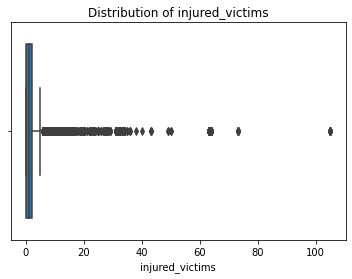

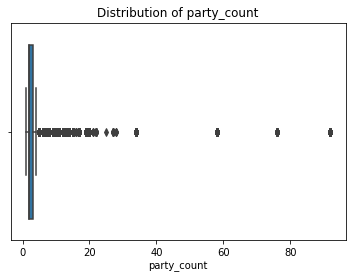

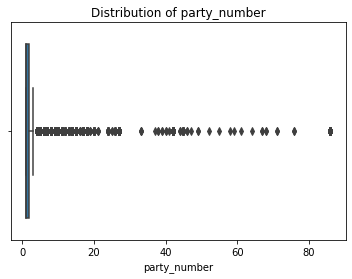

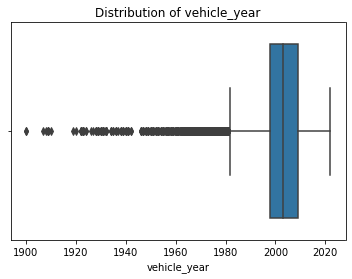

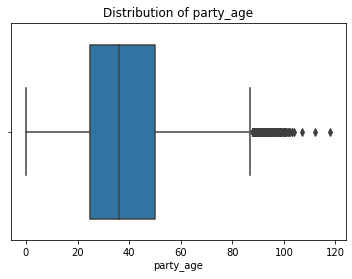

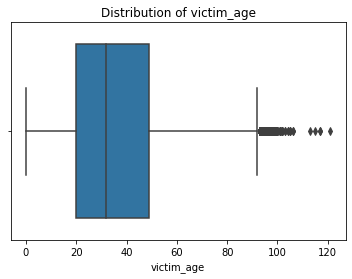

In [ ]:
potential_outlier_features = ['injured_victims', 'party_count', 'party_number', 
                              'vehicle_year', 'party_age', 'victim_age']

for feat in potential_outlier_features:
    ax = sns.boxplot(x=feat, data=X_train)
    plt.title('Distribution of {}'.format(feat))
    plt.show()

In [ ]:
# Remove outliers
X_train = X_train[X_train['injured_victims'] <= 40]
X_train = X_train[X_train['party_count'] <= 30]
X_train = X_train[X_train['party_number'] <= 30]
X_train = X_train[X_train['vehicle_year'] >= 1920]
X_train = X_train[X_train['party_age'] <= 100]
X_train = X_train[X_train['victim_age'] <= 100]
X_train.shape

(409382, 45)

In [ ]:
y_train = X_train.victim_degree_of_injury
X_train.drop(columns='victim_degree_of_injury', inplace=True)

# Correlations

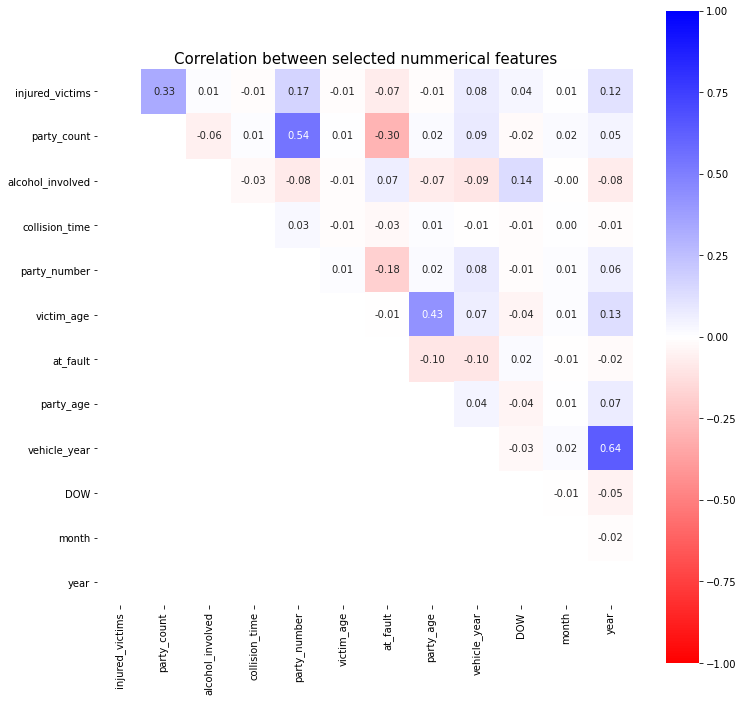

In [ ]:
# correlation plot:
f, axes = plt.subplots(figsize=(12,12))
corr = X_train.corr()
mask = np.tril(np.ones_like(corr, dtype=np.bool))
sns.heatmap(corr, annot=True, fmt=".2f", mask = mask, square = True, cmap="bwr_r",vmin=-1, vmax=1, center = 0)
plt.title('Correlation between selected nummerical features', size = 15);
plt.show()

# Categorical Feature Transformation

In [ ]:
cat_features = list(X_train.select_dtypes(include=['category','object']))
num_features = list(set(X_train.columns) - set(cat_features))
display("Categorical features are:",len(cat_features))
display("Numerical features are:",len(num_features))


'Categorical features are:'

32

'Numerical features are:'

12

In [ ]:
def compare_cols(train, test):
    train_col_lst = train.columns
    test_col_lst = test.columns
    for col in train_col_lst:
        if col not in test_col_lst:
            test[col] = np.zeros(len(test))
            
    for col in test_col_lst:
        if col not in train_col_lst:
            test.drop(columns=col, inplace=True)
    return train, test

In [ ]:
# Encoding categorical features using dummy encoder
dummies_train = pd.get_dummies(X_train[cat_features], drop_first=True)   
dummies_test = pd.get_dummies(X_test[cat_features], drop_first=True) 
dummies_train, dummies_test = compare_cols(dummies_train, dummies_test)
train = pd.concat([dummies_train, X_train[num_features]], axis=1)
test = pd.concat([dummies_test, X_test[num_features]], axis=1)
cat_w_dummies = dummies_train.columns

In [ ]:
train.shape

(409382, 213)

# Chi-Squared Feature Selection

In [ ]:
# keep top k categorical features
k = 60
fs = SelectKBest(score_func=chi2, k=k)
fs.fit(train[cat_w_dummies], y_train)
train_fs = fs.transform(train[cat_w_dummies])
test_fs = fs.transform(test[cat_w_dummies])

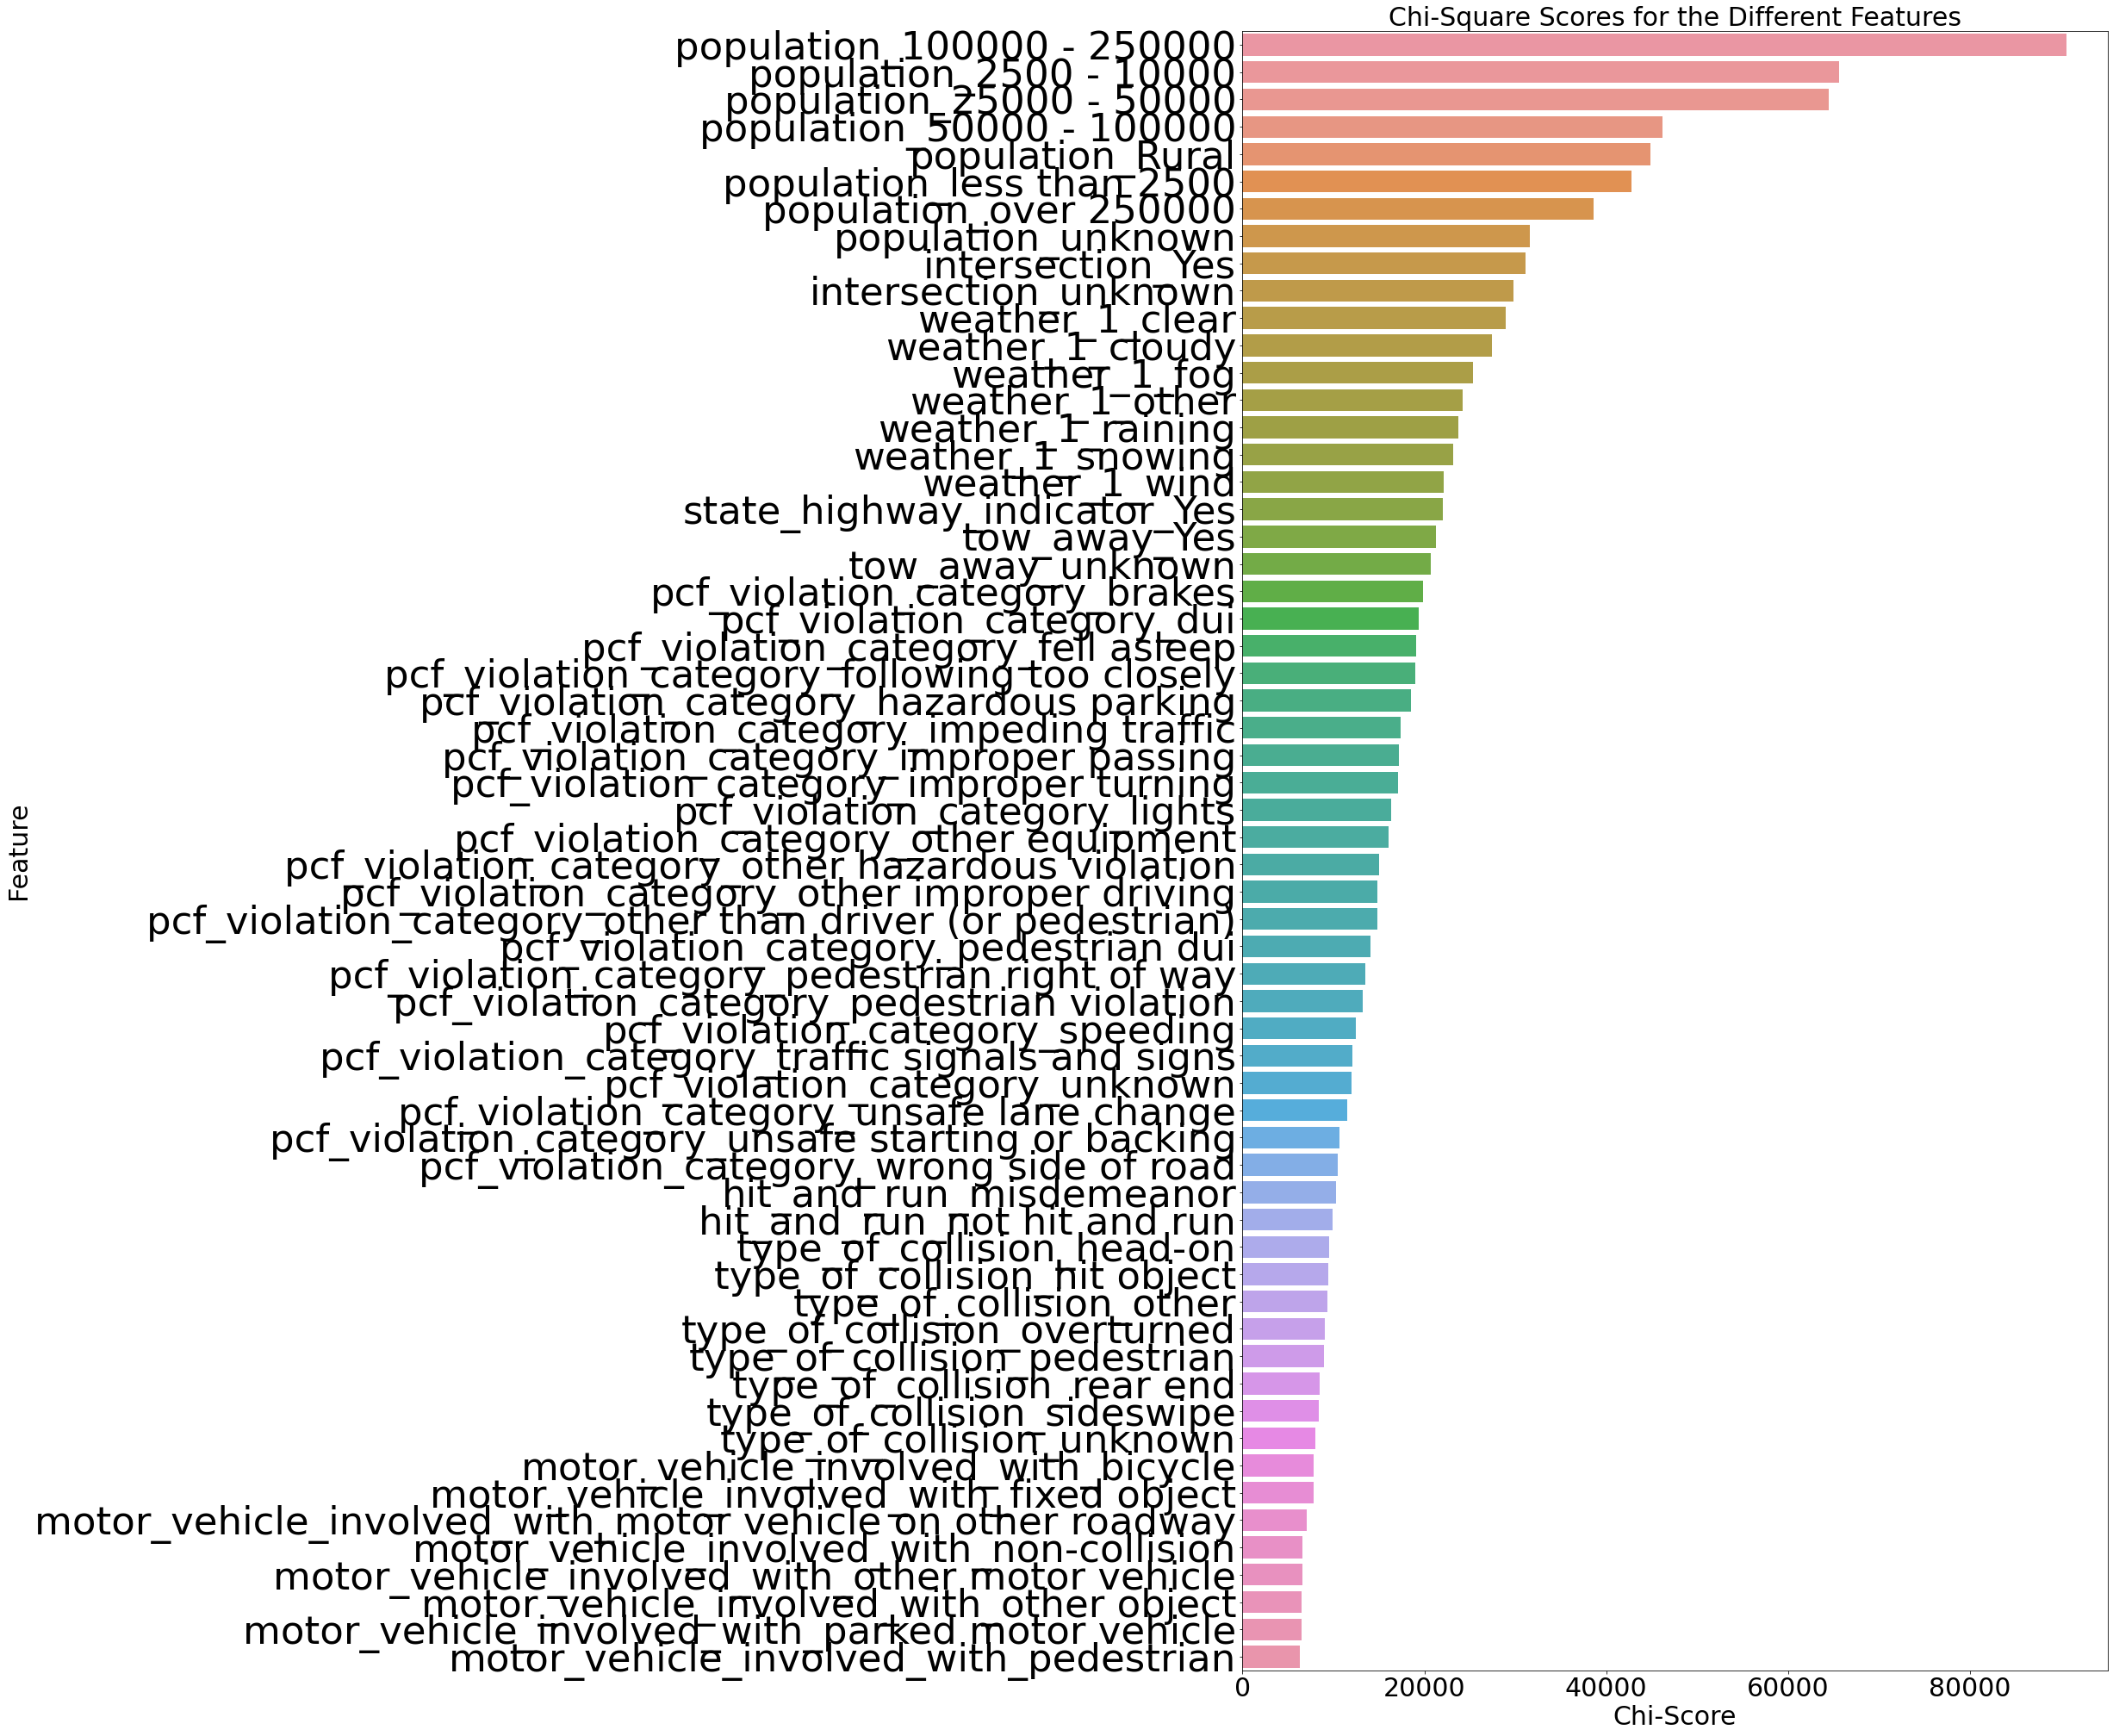

In [ ]:
fig, ax = plt.subplots(figsize=(18,35))
sns.barplot(y=cat_w_dummies[:k],x=sorted(fs.scores_, reverse=True)[:k])
plt.title("Chi-Square Scores for the Different Features", fontsize=30)
plt.ylabel("Feature", fontsize=30)
plt.xlabel("Chi-Score", fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=45)
plt.show()

In [ ]:
chi_train = train[train.columns[fs.get_support(indices=True)]]
chi_test = test[test.columns[fs.get_support(indices=True)]]
chi_train.shape, chi_test.shape

((409382, 60), (102515, 60))

In [ ]:
# Recombine numerical and categorical features
train_final = pd.concat([chi_train, train[num_features]], axis=1)
test_final = pd.concat([chi_test, test[num_features]], axis=1)

In [ ]:
train_final.shape,  test_final.shape

((409382, 72), (102515, 72))

# Standardize Data

In [ ]:
scaler = StandardScaler() 
X_train_scaled = scaler.fit_transform(train_final)
X_test_scaled = scaler.transform(test_final)

# Logistic Regression Model (Base Model)

In [ ]:
log_model = LogisticRegression(solver = "lbfgs", max_iter = 2000)
log_model.fit(X_train_scaled, y_train)
y_pred_logr = log_model.predict(X_test_scaled)

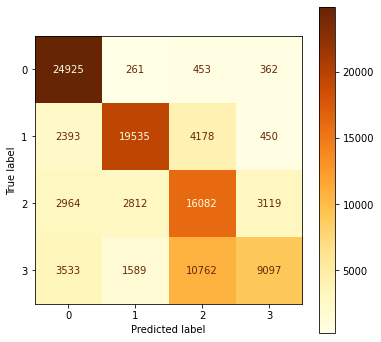

In [ ]:
f, axes = plt.subplots(figsize=(6,6))
plot_confusion_matrix(log_model, X_test_scaled, y_test,ax = axes, cmap = 'YlOrBr', values_format = '.0f');

In [ ]:
print(classification_report(y_test, y_pred_logr))

              precision    recall  f1-score   support

           0       0.74      0.96      0.83     26001
           1       0.81      0.74      0.77     26556
           2       0.51      0.64      0.57     24977
           3       0.70      0.36      0.48     24981

    accuracy                           0.68    102515
   macro avg       0.69      0.68      0.66    102515
weighted avg       0.69      0.68      0.67    102515



# KNN Classifier

In [ ]:
# from sklearn import neighbors

# knn_clf = neighbors.KNeighborsClassifier(n_neighbors = 10, weights = "distance")
# knn_clf.fit(X_train_scaled, y_train)  #fit the model
# Y_pred_KNN = knn_clf.predict(X_test_scaled) #make prediction on test set
# f, axes = plt.subplots(figsize=(6,6))
# plot_confusion_matrix(knn_clf, x_test_scaled, y_test,ax = axes, cmap = 'YlOrBr');

# Random Forest Classifier

In [ ]:
# ss_cv = ShuffleSplit(n_splits=4)

# N_ITER = 100 

# parameters = {'n_estimators': range(50, 450, 50), 
#               'max_depth': [2,5,8,11],
#               'min_samples_split': [2,4,6],
#               'min_samples_leaf' : [5,10]}

# rnd_gs = RandomizedSearchCV(RandomForestClassifier(), parameters,  
#                             scoring='accuracy', cv = ss_cv, verbose=10, n_iter=N_ITER, n_jobs = -1);

# rnd_gs.fit(X_train_scaled, y_train)

In [ ]:
# rnd_gs.best_params_

In [ ]:
# print("Best parameters set found on validation set:")
# print(rnd_gs.best_params_, '\n')

# print("Grid scores on validation set:")
# means = rnd_gs.cv_results_['mean_test_score']
# stds = rnd_gs.cv_results_['std_test_score']
# for mean_rfc, std_rfc, params_rfc in zip(means, stds, rnd_gs.cv_results_['params']):
#     print("%0.3f (+/-%0.03f) for %r"
#           % (mean_rfc, std_rfc * 2, params_rfc))

In [ ]:
parameters = {'n_estimators': 100,
 'min_samples_split': 6,
 'min_samples_leaf': 5,
 'max_depth': 11}

In [ ]:
# parameters = rnd_gs.best_params_

clf_RF = RandomForestClassifier(**parameters) 
clf_RF.fit(X_train_scaled, y_train)
y_pred_RF = clf_RF.predict(X_test_scaled)

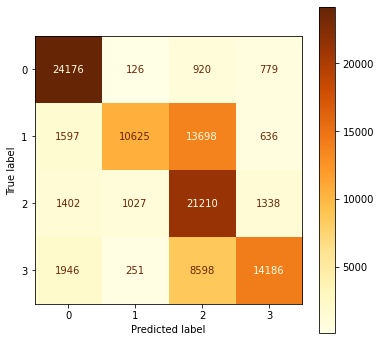

In [ ]:
f, axes = plt.subplots(figsize=(6,6))
plot_confusion_matrix(clf_RF, X_test_scaled, y_test,ax = axes, cmap = 'YlOrBr', values_format = '.0f');

In [ ]:
def get_stats(model, x_test_input=X_test, y_test_input=y_test,
             x_train_inp=X_train, y_train_inp=y_train):
    y_pred = np.round(model.predict(x_test_input))
    y_pred_train = np.round(model.predict(x_train_inp))
    accuracy_test = accuracy_score(y_test_input, y_pred)
    accuracy_train = accuracy_score(y_train_inp, y_pred_train)
    print("Accuracy Test: {0}".format(round(accuracy_test, 3)))
    print("Accuracy Train: {0}".format(round(accuracy_train, 3)))
    print(classification_report(y_test_input, y_pred))

get_stats(clf_RF, X_test_scaled, y_test, X_train_scaled, y_train)

Accuracy Test: 0.685
Accuracy Train: 0.827
              precision    recall  f1-score   support

           0       0.83      0.93      0.88     26001
           1       0.88      0.40      0.55     26556
           2       0.48      0.85      0.61     24977
           3       0.84      0.57      0.68     24981

    accuracy                           0.68    102515
   macro avg       0.76      0.69      0.68    102515
weighted avg       0.76      0.68      0.68    102515



# Deep Learning Model

In [ ]:
# Transform y to one-hot vectors
encoder = LabelEncoder()
encoder.fit(y_train)
encoded_y = encoder.transform(y_train)
dummy_y = np_utils.to_categorical(encoded_y)

In [ ]:
# Function to build network framework
def create_model():
  mc_model = Sequential([
                             Input(shape=(X_train_scaled.shape[1]), name='basket'),
                             layers.Dense(64, input_dim=X_train_scaled.shape[1], activation='relu', name='dense_1'), 
                             layers.Dense(32, activation='relu', name='dense_2'),
                             layers.Dense(16, activation='relu', name='dense_3'),
                             layers.Dense(4, activation='softmax', name='output')])
  # I turned 32 to 64... and added another 32!
  mc_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['Precision', 'Recall'])
  return mc_model

In [ ]:
# Create and train model
backend.clear_session()

estimator = KerasClassifier(build_fn=create_model, epochs=50, batch_size=32)
estimator.fit(X_train_scaled, dummy_y)

Epoch 1/50
12794/12794 [==============================] - 22s 2ms/step - loss: 0.4802 - precision: 0.8268 - recall: 0.7470
Epoch 2/50
12794/12794 [==============================] - 20s 2ms/step - loss: 0.3684 - precision: 0.8590 - recall: 0.8231
Epoch 3/50
12794/12794 [==============================] - 20s 2ms/step - loss: 0.3574 - precision: 0.8626 - recall: 0.8296
Epoch 4/50
12794/12794 [==============================] - 20s 2ms/step - loss: 0.3515 - precision: 0.8649 - recall: 0.8329
Epoch 5/50
12794/12794 [==============================] - 20s 2ms/step - loss: 0.3478 - precision: 0.8656 - recall: 0.8360
Epoch 6/50
12794/12794 [==============================] - 20s 2ms/step - loss: 0.3449 - precision: 0.8665 - recall: 0.8371
Epoch 7/50
12794/12794 [==============================] - 20s 2ms/step - loss: 0.3425 - precision: 0.8674 - recall: 0.8379
Epoch 8/50
12794/12794 [==============================] - 20s 2ms/step - loss: 0.3421 - precision: 0.8674 - recall: 0.8388
Epoch 9/50
12794

In [ ]:
encoded_test = encoder.transform(y_test)
dummy_test = np_utils.to_categorical(encoded_test)

In [ ]:
# Test model performance
predicted = estimator.predict(X_test_scaled)
report = classification_report(y_test, predicted)
print(report)

`model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


              precision    recall  f1-score   support

           0       0.74      0.95      0.83     26001
           1       0.86      0.66      0.75     26556
           2       0.58      0.70      0.63     24977
           3       0.78      0.59      0.67     24981

    accuracy                           0.72    102515
   macro avg       0.74      0.72      0.72    102515
weighted avg       0.74      0.72      0.72    102515



# CatBoost classifier

In [ ]:
from catboost import Pool, CatBoostClassifier

In [ ]:
X_train_scaled, X_val_scaled, y_train, y_val = train_test_split(X_train_scaled, y_train, 
                                                    test_size=0.20, 
                                                    random_state=42, 
                                                    stratify = y_train, 
                                                    shuffle = True)

In [ ]:
train_pool = Pool(data=X_train_scaled, label=y_train)
val_pool = Pool(data=X_val_scaled, label=y_val) 

In [ ]:
model = CatBoostClassifier(
    iterations=200,
    learning_rate=0.1,
    l2_leaf_reg=4,
    depth=4,
    loss_function='MultiClassOneVsAll',
    eval_metric='Accuracy',
    od_type = 'IncToDec',
    od_pval = 10**-2)

In [ ]:
model.fit(train_pool,plot=True,eval_set=val_pool)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.7632555	test: 0.7592486	best: 0.7592486 (0)	total: 445ms	remaining: 1m 28s
1:	learn: 0.7632555	test: 0.7592486	best: 0.7592486 (0)	total: 742ms	remaining: 1m 13s
2:	learn: 0.7632555	test: 0.7592486	best: 0.7592486 (0)	total: 1.03s	remaining: 1m 7s
3:	learn: 0.7632555	test: 0.7592486	best: 0.7592486 (0)	total: 1.35s	remaining: 1m 5s
4:	learn: 0.7632555	test: 0.7592486	best: 0.7592486 (0)	total: 1.64s	remaining: 1m 3s
5:	learn: 0.7632555	test: 0.7592486	best: 0.7592486 (0)	total: 1.94s	remaining: 1m 2s
6:	learn: 0.7632555	test: 0.7592486	best: 0.7592486 (0)	total: 2.25s	remaining: 1m 2s
7:	learn: 0.7632555	test: 0.7592486	best: 0.7592486 (0)	total: 2.54s	remaining: 1m
8:	learn: 0.7648341	test: 0.7606654	best: 0.7606654 (8)	total: 2.83s	remaining: 1m
9:	learn: 0.7642601	test: 0.7602501	best: 0.7606654 (8)	total: 3.14s	remaining: 59.7s
10:	learn: 0.7685409	test: 0.7645248	best: 0.7645248 (10)	total: 3.44s	remaining: 59s
11:	learn: 0.7693379	test: 0.7651599	best: 0.7651599 (11)	

In [ ]:
catboost_pred = model.predict(X_test_scaled)

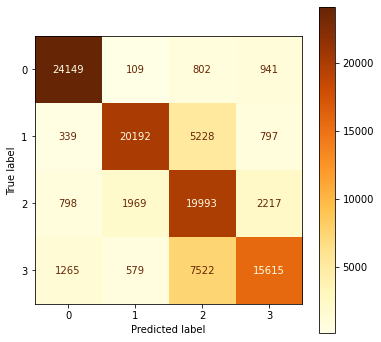

In [ ]:
f, axes = plt.subplots(figsize=(6,6))
plot_confusion_matrix(model, X_test_scaled, y_test,ax = axes, cmap = 'YlOrBr', values_format = '.0f');

In [ ]:
get_stats(model, X_test_scaled, y_test, X_train_scaled, y_train)

Accuracy Test: 0.78
Accuracy Train: 0.841
              precision    recall  f1-score   support

           0       0.91      0.93      0.92     26001
           1       0.88      0.76      0.82     26556
           2       0.60      0.80      0.68     24977
           3       0.80      0.63      0.70     24981

    accuracy                           0.78    102515
   macro avg       0.80      0.78      0.78    102515
weighted avg       0.80      0.78      0.78    102515



# XGBOOST

In [ ]:
dtrain = xgb.DMatrix(data=X_train_scaled, label=y_train)
dtest = xgb.DMatrix(data=X_test_scaled)

In [ ]:
params = {
    'max_depth': 3,
    'objective': 'multi:softmax',  # error evaluation for multiclass training
    'num_class': 4
}

bst = xgb.train(params, dtrain)
pred_xgb = bst.predict(dtest)

In [ ]:
print(classification_report(y_test, pred_xgb))

              precision    recall  f1-score   support

           0       0.87      0.94      0.90     26001
           1       0.82      0.93      0.87     26556
           2       0.63      0.76      0.69     24977
           3       0.90      0.51      0.65     24981

    accuracy                           0.79    102515
   macro avg       0.80      0.79      0.78    102515
weighted avg       0.81      0.79      0.78    102515



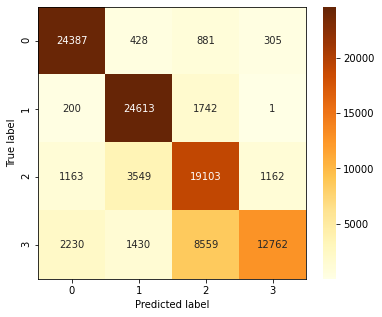

In [ ]:
f, axes = plt.subplots(figsize=(6,5))
sns.heatmap(confusion_matrix(y_test, pred_xgb), cmap = "YlOrBr", fmt=".0f", annot=True);
for axis in ['top','bottom','left','right']:
  axes.spines[axis].set_visible(True)
  axes.spines[axis].set_color('black')
  axes.spines[axis].set_visible(True)
  axes.spines[axis].set_color('black')
plt.xlabel("Predicted label");
plt.ylabel("True label");

# Shap - explainer on RF:

In [ ]:
# x_tr = pd.DataFrame(X_train_scaled, columns = train_final.columns)
# x_ts = pd.DataFrame(X_test_scaled, columns = test_final.columns)

# clf_RF = RandomForestClassifier(**parameters) 
# clf_RF.fit(x_tr, y_train)
# y_pred_RF = clf_RF.predict(x_ts)

# explainer = shap.TreeExplainer(clf_RF)
# shap_values = explainer.shap_values(x_tr)
# # alternatively features importance from previous section for random forest, using shap:
# shap.summary_plot(shap_values, x_ts)

# Shap - explainer on Catboost:

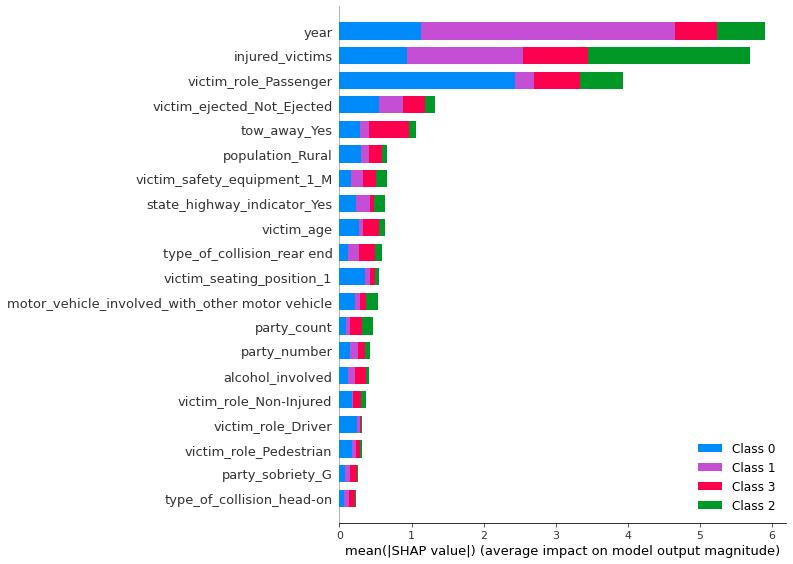

In [ ]:
x_tr = pd.DataFrame(X_train_scaled, columns = train_final.columns)
x_ts = pd.DataFrame(X_test_scaled, columns = test_final.columns)

explainer2 = shap.TreeExplainer(model)
shap_values2 = explainer2.shap_values(x_tr)
shap.summary_plot(shap_values2, x_tr) # or x_ts?!?

# Feature importance XGboost:

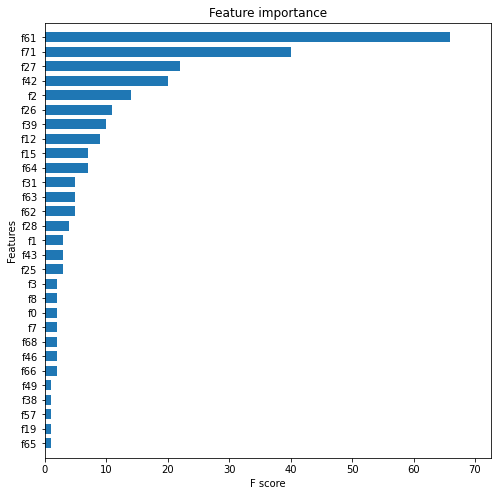

In [ ]:
ax = xgb.plot_importance(bst, height = 0.7 , grid=False, show_values=False)
fig = ax.figure
fig.set_size_inches(8, 8)

# Comparison between models:

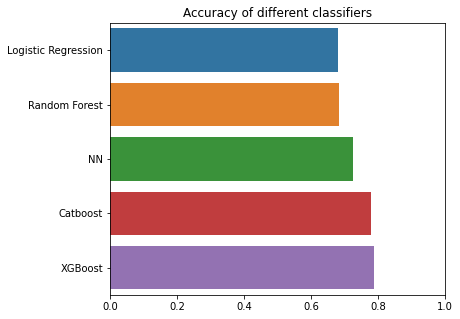

In [ ]:
f, axes = plt.subplots(figsize=(6,5))
results = [accuracy_score(y_test, y_pred_logr), 
          accuracy_score(y_test, y_pred_RF),
          accuracy_score(y_test, predicted),
          accuracy_score(y_test, catboost_pred), 
          accuracy_score(y_test, pred_xgb)]
models = ["Logistic Regression", "Random Forest", "NN", "Catboost", "XGBoost"]
sns.barplot(y = models,x = results);
plt.title("Accuracy of different classifiers");
plt.xlim([0,1]);

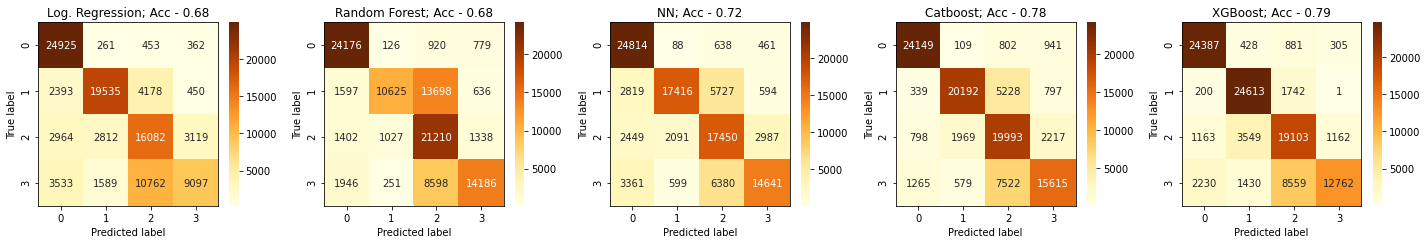

In [ ]:
f, axes = plt.subplots(1,5,figsize=(20,3.5))
models = [y_pred_logr, y_pred_RF, predicted, catboost_pred, pred_xgb]
model_names = ["Log. Regression", "Random Forest", "NN", "Catboost", "XGBoost"]
for sub_plot,model,model_name, accuracy in zip(range(5),models,model_names, results):
  sns.heatmap(confusion_matrix(y_test, model), cmap = "YlOrBr", fmt=".0f", annot=True, ax = axes[sub_plot]);
  for axis in ['top','bottom','left','right']:
    axes[sub_plot].spines[axis].set_visible(True)
    axes[sub_plot].spines[axis].set_color('black')
    axes[sub_plot].spines[axis].set_visible(True)
    axes[sub_plot].spines[axis].set_color('black')
  axes[sub_plot].set_title(model_name+"; Acc - "+str(round(accuracy,2)));
  axes[sub_plot].set_xlabel("Predicted label");
  axes[sub_plot].set_ylabel("True label");
plt.tight_layout()

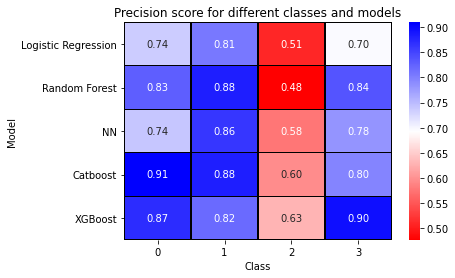

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

pr_1 = precision_score(y_test, y_pred_logr, average=None) #LGR
pr_2 = precision_score(y_test, y_pred_RF, average=None) # RFC
pr_3 = precision_score(y_test, predicted, average=None) # NN model
pr_4 = precision_score(y_test, catboost_pred, average=None) #CATBOOST
pr_5 = precision_score(y_test, pred_xgb, average=None) #XGBOOST
arr = np.concatenate((pr_1,pr_2, pr_3, pr_4, pr_5), axis = 0).reshape(5,4)
y_axis_labels = ["Logistic Regression", 'Random Forest', "NN",'Catboost','XGBoost']
sns.heatmap(arr, cmap="bwr_r",fmt=".2f", annot=True,linewidths=0.1, linecolor='black', yticklabels=y_axis_labels);
plt.xlabel("Class")
plt.ylabel("Model");
plt.title("Precision score for different classes and models");

Text(0.5, 1.0, 'Recall score for different classes and models')

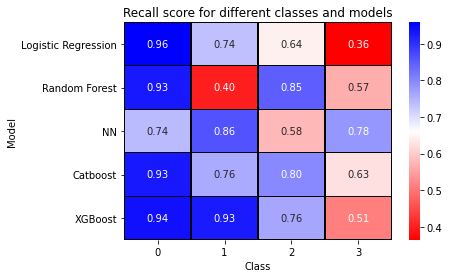

In [ ]:
pr_1 = recall_score(y_test, y_pred_logr, average=None) #LGR
pr_2 = recall_score(y_test, y_pred_RF, average=None) # RFC
pr_3 = precision_score(y_test, predicted, average=None) # NN model
pr_4 = recall_score(y_test, catboost_pred, average=None) #CATBOOST
pr_5 = recall_score(y_test, pred_xgb, average=None) #XGBOOST
arr = np.concatenate((pr_1,pr_2, pr_3, pr_4, pr_5), axis = 0).reshape(5,4)
y_axis_labels = ["Logistic Regression", 'Random Forest', "NN",'Catboost','XGBoost']
sns.heatmap(arr, cmap="bwr_r",fmt=".2f", annot=True,linewidths=0.1, linecolor='black', yticklabels=y_axis_labels);
plt.xlabel("Class")
plt.ylabel("Model");
plt.title("Recall score for different classes and models")